In [1]:
import numpy as np
import math
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
from matplotlib import patches


In [2]:
netflix = Table.read_table("titles.csv")
netflix_t = Table().with_columns(
            "runtime",netflix.column("runtime"),
            "imdb_score",netflix.column("imdb_score"),
            "type",netflix.column("type")).where("type", are.equal_to("SHOW")).drop("type").where("imdb_score",are.between(0,11)).where("runtime", are.above_or_equal_to(6))
#netflix_t = netflix_t.sample(k = 3113)
netflix_t#.sort("runtime")

runtime,imdb_score
30,8.8
43,8.1
24,8.9
51,6.9
10,6.5
23,7.1
26,6.7
24,6.4
10,6.1
15,7.4


In [3]:
#netflix.where("runtime", are.between(0,3)).sort("runtime",descending=True)

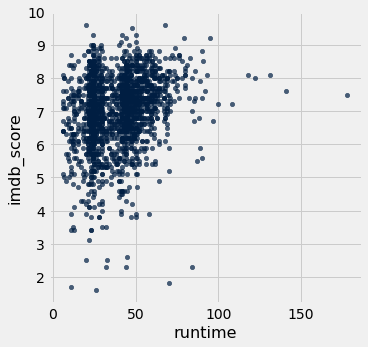

In [4]:
netflix_t.scatter("runtime")

In [5]:
runtime_mean = np.mean(netflix_t.column("runtime"))
imdb_score_mean = np.mean(netflix_t.column("imdb_score"))
runtime_std = np.std(netflix_t.column("runtime"))
imdb_score_std = np.std(netflix_t.column("imdb_score"))

netflix_t_su = Table().with_columns(
               "runtime (SU)",(netflix_t.column("runtime")-runtime_mean)/runtime_std,
               "imdb_score (SU)",(netflix_t.column("imdb_score")-imdb_score_mean)/imdb_score_std)
netflix_t_su

runtime (SU),imdb_score (SU)
-0.550729,1.65596
0.211588,1.00533
-0.902568,1.7489
0.680707,-0.11004
-1.72352,-0.481828
-0.961208,0.0758546
-0.785288,-0.295934
-0.902568,-0.574775
-1.72352,-0.853617
-1.43033,0.354696


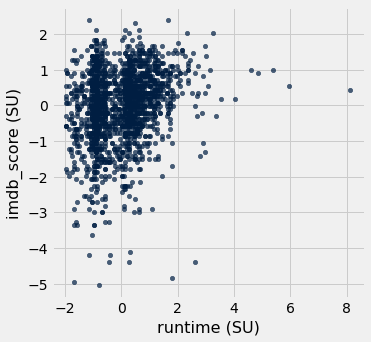

In [6]:
netflix_t_su.scatter("runtime (SU)")

In [7]:
netflix_t_r = np.mean(netflix_t_su.column(0)*netflix_t_su.column(1))
netflix_t_slope = netflix_t_r*(imdb_score_std/runtime_std)
netflix_t_inter = imdb_score_mean - netflix_t_slope * runtime_mean
print("r:", netflix_t_r, ", slope:", netflix_t_slope, ", intercept:", netflix_t_inter)

r: 0.23457364714061368 , slope: 0.01479910834767405 , intercept: 6.435427071497118


In [8]:
prediction_su = netflix_t_su.with_columns("prediction", netflix_t_r * netflix_t_su.column("runtime (SU)"))
prediction_su

runtime (SU),imdb_score (SU),prediction
-0.550729,1.65596,-0.129187
0.211588,1.00533,0.049633
-0.902568,1.7489,-0.211719
0.680707,-0.11004,0.159676
-1.72352,-0.481828,-0.404294
-0.961208,0.0758546,-0.225474
-0.785288,-0.295934,-0.184208
-0.902568,-0.574775,-0.211719
-1.72352,-0.853617,-0.404294
-1.43033,0.354696,-0.335517


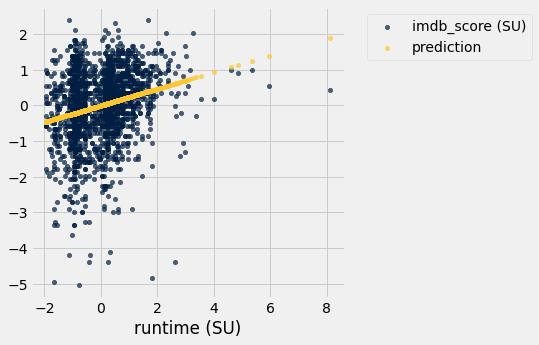

In [9]:
prediction_su.scatter("runtime (SU)")

In [10]:
prediction = netflix_t.with_columns("prediction", netflix_t_slope * netflix_t.column("runtime") + netflix_t_inter)
prediction

runtime,imdb_score,prediction
30,8.8,6.8794
43,8.1,7.07179
24,8.9,6.79061
51,6.9,7.19018
10,6.5,6.58342
23,7.1,6.77581
26,6.7,6.8202
24,6.4,6.79061
10,6.1,6.58342
15,7.4,6.65741


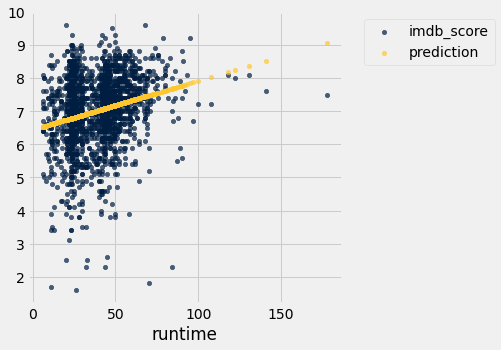

In [11]:
prediction.scatter("runtime")

In [12]:
prediction = prediction.with_columns("error", prediction.column("imdb_score")-prediction.column("prediction"))
prediction = prediction.with_columns("error^2", prediction.column("error")**2)
prediction

runtime,imdb_score,prediction,error,error^2
30,8.8,6.8794,1.9206,3.6887
43,8.1,7.07179,1.02821,1.05722
24,8.9,6.79061,2.10939,4.44954
51,6.9,7.19018,-0.290182,0.0842054
10,6.5,6.58342,-0.0834182,0.00695859
23,7.1,6.77581,0.324193,0.105101
26,6.7,6.8202,-0.120204,0.014449
24,6.4,6.79061,-0.390606,0.152573
10,6.1,6.58342,-0.483418,0.233693
15,7.4,6.65741,0.742586,0.551434


In [13]:
rmse = np.sqrt(np.mean(prediction.column("error^2")))
rmse

1.045861361622285

Conclusion: hay una correlacion positiva entre el numero de episodios y la calificacion que recive por parte de IMDB

In [14]:
def mean_based_estimator(nums):
    return np.mean(nums)*2

def simulate_estimates(original_table, sample_size, statistic, num_replications, label):
    results = []
    for i in np.arange(num_replications):
        resample = original_table.sample(k = sample_size)
        aux = statistic(resample.column(label))
        results.append(aux)
    return results

bootstrap_estimates = Table().with_columns(
    "runtime",simulate_estimates(netflix_t,3802,mean_based_estimator,5000,"runtime"),
    "imdb_score",simulate_estimates(netflix_t,3802,mean_based_estimator,5000,"imdb_score"))
bootstrap_estimates

runtime,imdb_score
79.7696,14.084
79.5302,13.9924
78.6954,13.9602
79.6802,14.0326
78.5576,14.0308
78.344,14.0374
78.7254,14.0436
79.1815,14.0875
78.7564,14.0144
79.5287,14.0139


Middle 95% of bootstrap estimates: [13.970431, 14.088746]


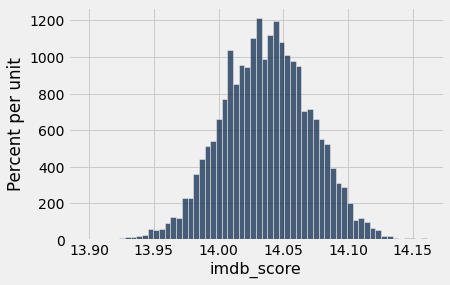

In [15]:
bootstrap_estimates.hist("imdb_score",bins=60)
new_left_end = np.percentile(bootstrap_estimates.column("imdb_score"),2.5)
new_right_end =  np.percentile(bootstrap_estimates.column("imdb_score"),93.5)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

Middle 95% of bootstrap estimates: [77.715400, 79.615500]


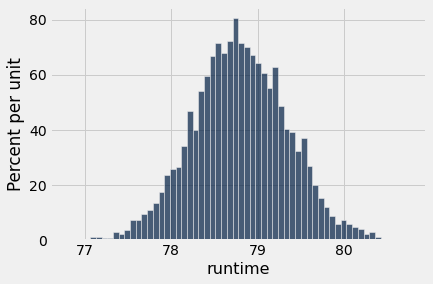

In [16]:
bootstrap_estimates.hist("runtime",bins=60)
new_left_end = np.percentile(bootstrap_estimates.column("runtime"),2.5)
new_right_end =  np.percentile(bootstrap_estimates.column("runtime"),93.5)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))